In [6]:
install.packages("psych")

Installing package into 'C:/Users/52552/AppData/Local/R/win-library/4.2'
(as 'lib' is unspecified)

also installing the dependency 'mnormt'




package 'mnormt' successfully unpacked and MD5 sums checked
package 'psych' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\52552\AppData\Local\Temp\RtmpQb86P7\downloaded_packages


In [7]:
# Load libraries, get data & set seed for reproducibility
set.seed(123)    # seef for reproducibility
library(glmnet)  # for ridge regression
library(dplyr)   # for data cleaning
library(psych)   # for function tr() to compute trace of a matrix

Este código de R carga el conjunto de datos "mtcars" y luego selecciona la columna "mpg" para la variable de respuesta (y), y todas las demás columnas para las variables explicativas (X). La variable de respuesta (y) se centra para tener media cero, y las variables explicativas (X) se estandarizan dividiéndolas por su desviación estándar. Esto es comúnmente utilizado en la regresión lineal para asegurar que todas las variables tengan una escala comparable y para centrar la media de la variable de respuesta en cero, lo que facilita la interpretación de los coeficientes.

In [8]:
data("mtcars")
# Center y, X will be standardized in the modelling function
y <-
  mtcars %>% select(mpg) %>% scale(center = TRUE, scale = FALSE) %>% as.matrix()
X <- mtcars %>% select(-mpg) %>% as.matrix()

Este código realiza una regresión de ridge sobre los datos previamente cargados y preprocesados. Se realiza una búsqueda de hiperparámetros para encontrar el mejor valor de lambda utilizando validación cruzada de 10 pliegues. Luego, se ajusta un modelo final utilizando el mejor valor de lambda y se calcula la suma de residuos cuadrados (ssr_cv) y el coeficiente de determinación múltiple (rsq_ridge_cv) del modelo final. La regresión de ridge es una técnica de regularización que agrega una penalización al cuadrado en los coeficientes de la regresión con el fin de evitar el sobreajuste del modelo. En este caso, se utiliza una regresión de ridge con el parámetro de regularización lambda seleccionado a través de la validación cruzada de 10 pliegues. El valor de lambda seleccionado proporciona el mejor equilibrio entre ajuste y complejidad del modelo.

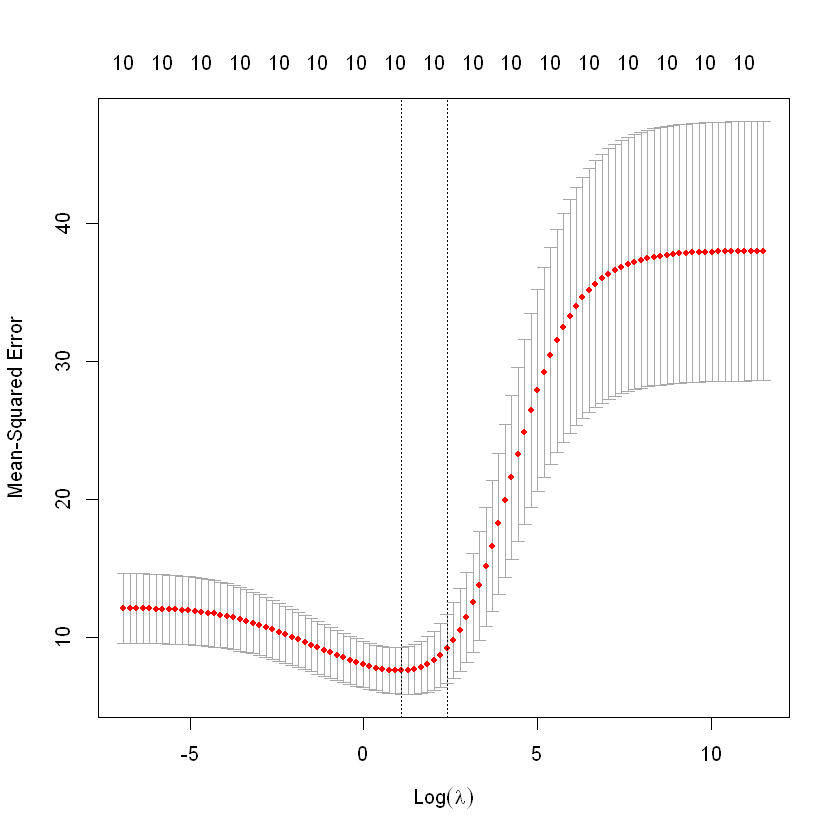

In [9]:
# Perform 10-fold cross-validation to select lambda
lambdas_to_try <- 10 ^ seq(-3, 5, length.out = 100)
# Setting alpha = 0 implements ridge regression
ridge_cv <- cv.glmnet(
  X,
  y,
  alpha = 0,
  lambda = lambdas_to_try,
  standardize = TRUE,
  nfolds = 10
)
# Plot cross-validation results
plot(ridge_cv)

# Best cross-validated lambda
lambda_cv <- ridge_cv$lambda.min
# Fit final model, get its sum of squared residuals and multiple R-squared
model_cv <-
  glmnet(X,
         y,
         alpha = 0,
         lambda = lambda_cv,
         standardize = TRUE)
y_hat_cv <- predict(model_cv, X)
ssr_cv <- t(y - y_hat_cv) %*% (y - y_hat_cv)
rsq_ridge_cv <- cor(y, y_hat_cv) ^ 2

En la gráfica anterior muestra las mejores lambdas. No estrictamente la de menor error ya que eso puede significar un sobrenetrenamiento, por lo que se toman aquellas que están una desviación estándar (de las medias de las lambdas) a la derecha.

Los puntos rojos son la media de las lambdas

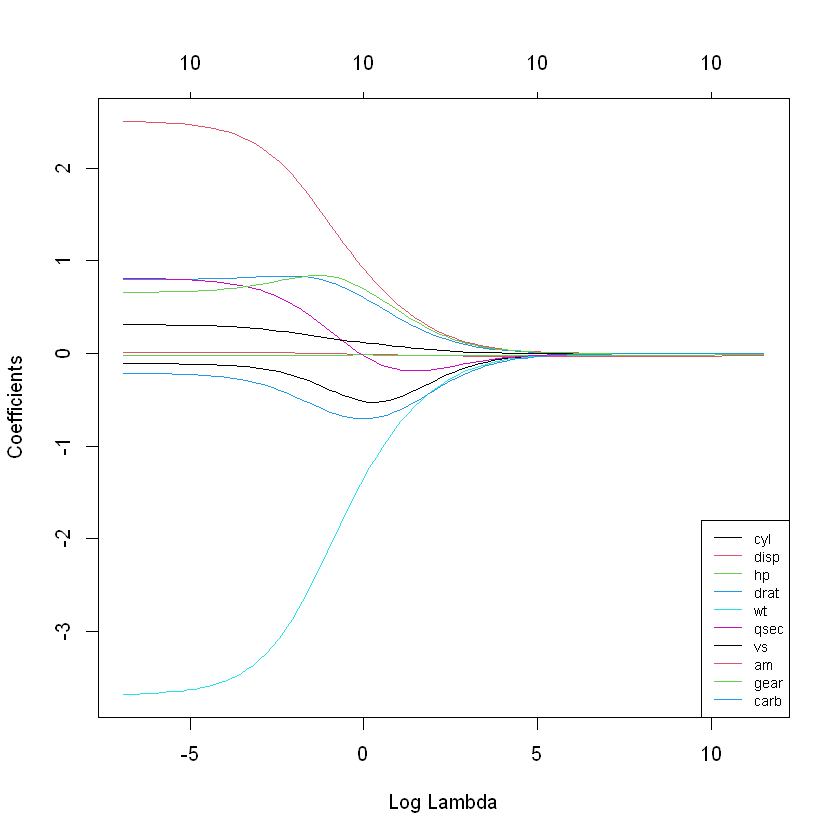

In [11]:
# See how increasing lambda shrinks the coefficients
# Each line shows coefficients for one variables, for different lambdas.
# The higher the lambda, the more the coefficients are shrinked towards zero.
res <-
  glmnet(X,
         y,
         alpha = 0,
         lambda = lambdas_to_try,
         standardize = FALSE)
plot(res, xvar = "lambda")
legend(
  "bottomright",
  lwd = 1,
  col = 1:6,
  legend = colnames(X),
  cex = .7
)

En este segundo plot, vemos las variables de "mtcars". En el eje y están los coeficientes de las variables a la hora de aplicar una regresión lineal sin regularización.

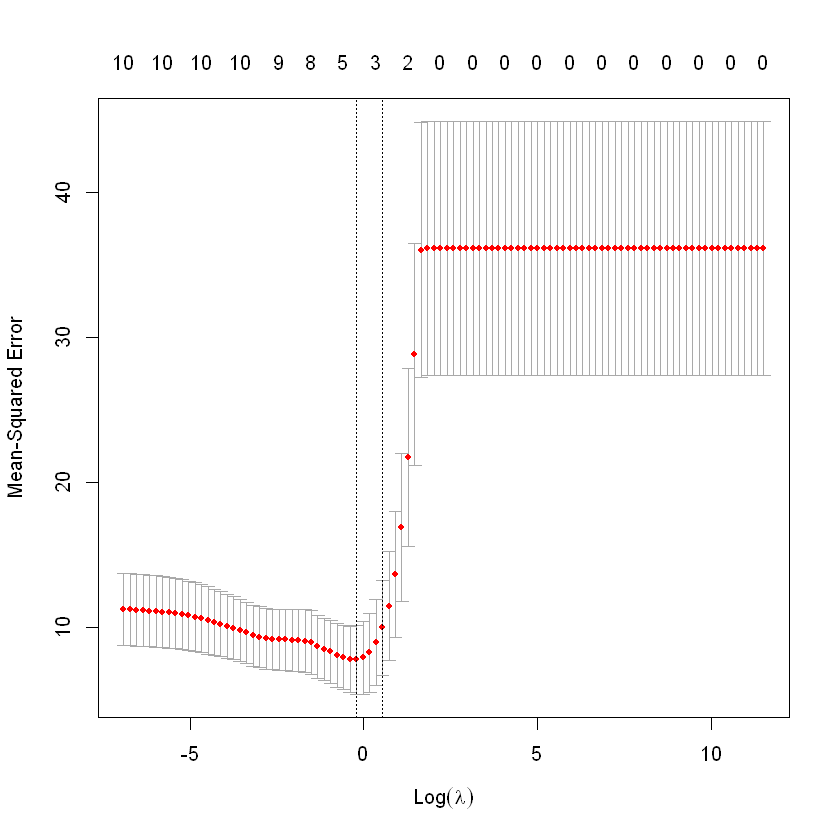

In [6]:
# Lasso

# Perform 10-fold cross-validation to select lambda
lambdas_to_try <- 10 ^ seq(-3, 5, length.out = 100)

# Setting alpha = 1 implements lasso regression
lasso_cv <- cv.glmnet(
  X,
  y,
  alpha = 1,
  lambda = lambdas_to_try,
  standardize = TRUE,
  nfolds = 10
)
# Plot cross-validation results
plot(lasso_cv)

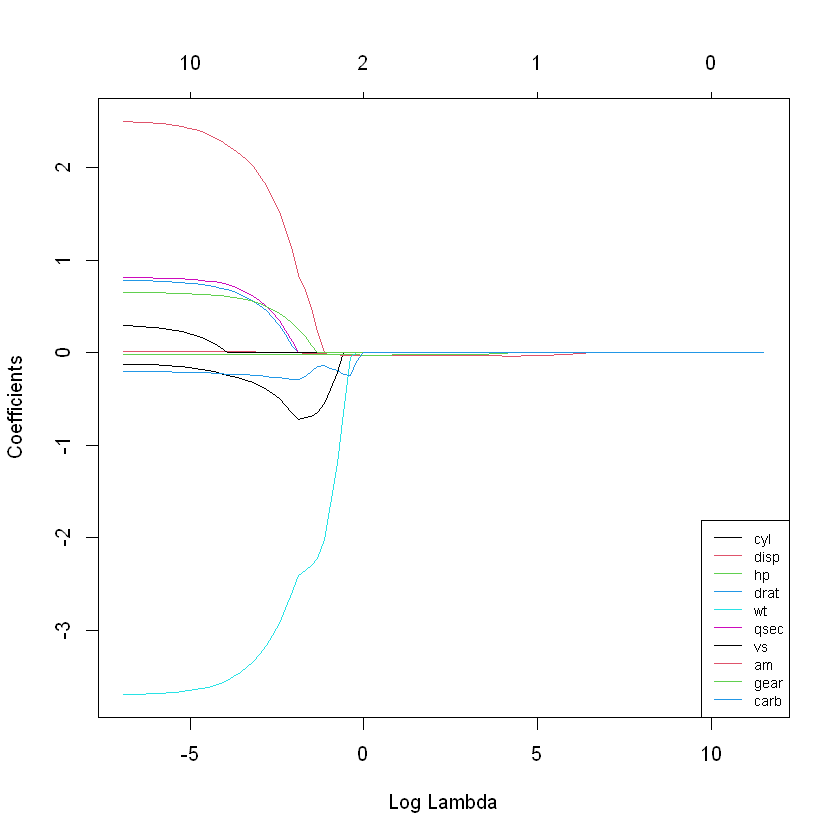

In [8]:
# Best cross-validated lambda
lambda_cv <- lasso_cv$lambda.min
# Fit final model, get its sum of squared residuals and multiple R-squared
model_cv <-
  glmnet(X,
         y,
         alpha = 1,
         lambda = lambda_cv,
         standardize = TRUE)
y_hat_cv <- predict(model_cv, X)
ssr_cv <- t(y - y_hat_cv) %*% (y - y_hat_cv)
rsq_lasso_cv <- cor(y, y_hat_cv) ^ 2


# See how increasing lambda shrinks the coefficients
# Each line shows coefficients for one variables, for different lambdas.
# The higher the lambda, the more the coefficients are shrinked towards zero.
res <-
  glmnet(X,
         y,
         alpha = 1,
         lambda = lambdas_to_try,
         standardize = FALSE)
plot(res, xvar = "lambda")
legend(
  "bottomright",
  lwd = 1,
  col = 1:6,
  legend = colnames(X),
  cex = .7
)


In [9]:
library(caret)

# Set training control
train_control <- trainControl(
  method = "repeatedcv",
  number = 5,
  repeats = 5,
  search = "random",
  verboseIter = TRUE
)

# Train the model
elastic_net_model <- train(
  mpg ~ .,
  data = cbind(y, X),
  method = "glmnet",
  preProcess = c("center", "scale"),
  tuneLength = 25,
  trControl = train_control
)

# Check multiple R-squared
y_hat_enet <- predict(elastic_net_model, X)
rsq_enet <- cor(y, y_hat_enet) ^ 2

Warning message:
"package 'caret' was built under R version 4.0.5"
Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.0.5"

Attaching package: 'ggplot2'


The following objects are masked from 'package:psych':

    %+%, alpha


Loading required package: lattice



+ Fold1.Rep1: alpha=0.78229, lambda=0.017429 
- Fold1.Rep1: alpha=0.78229, lambda=0.017429 
+ Fold1.Rep1: alpha=0.09359, lambda=0.015629 
- Fold1.Rep1: alpha=0.09359, lambda=0.015629 
+ Fold1.Rep1: alpha=0.46678, lambda=0.007075 
- Fold1.Rep1: alpha=0.46678, lambda=0.007075 
+ Fold1.Rep1: alpha=0.51151, lambda=0.027268 
- Fold1.Rep1: alpha=0.51151, lambda=0.027268 
+ Fold1.Rep1: alpha=0.59999, lambda=6.939586 
- Fold1.Rep1: alpha=0.59999, lambda=6.939586 
+ Fold1.Rep1: alpha=0.33282, lambda=0.003919 
- Fold1.Rep1: alpha=0.33282, lambda=0.003919 
+ Fold1.Rep1: alpha=0.48861, lambda=0.002218 
- Fold1.Rep1: alpha=0.48861, lambda=0.002218 
+ Fold1.Rep1: alpha=0.95447, lambda=0.003508 
- Fold1.Rep1: alpha=0.95447, lambda=0.003508 
+ Fold1.Rep1: alpha=0.48290, lambda=0.489741 
- Fold1.Rep1: alpha=0.48290, lambda=0.489741 
+ Fold1.Rep1: alpha=0.89035, lambda=0.258876 
- Fold1.Rep1: alpha=0.89035, lambda=0.258876 
+ Fold1.Rep1: alpha=0.91444, lambda=3.006580 
- Fold1.Rep1: alpha=0.91444, lambd

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


Aggregating results
Selecting tuning parameters
Fitting alpha = 0.0607, lambda = 1.17 on full training set
